# Topic Modeling of Job Descriptions\n
\n
This notebook explores different topic modeling techniques (LDA, NMF) on the processed job descriptions dataset. We will perform hyperparameter tuning for LDA and visualize the results.

In [1]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.lda_model # Use lda_model for sklearn
from wordcloud import WordCloud

# Download necessary NLTK data (if not already downloaded)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/gabriel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Data

In [12]:
# Set up project root path to import custom modules or load data\n
project_root = os.path.abspath(
    os.path.join(os.getcwd(), '../../..')
)
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Project Root: {project_root}")

from models.src.preprocessing.normalizer import TextNormalizer

normalizer = TextNormalizer()

Project Root: /home/gabriel/dev/SCIA/NLP_Linkedin_offers


/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/gabriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/gabriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gabriel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Load the processed dataset\n
data_path = os.path.join(
    project_root, 'data', 'processed', 'cleaned_postings_modeling.parquet'
)

try:
    df = pd.read_parquet(data_path)
    print(f"Successfully loaded data from {data_path}")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file '{os.path.basename(data_path)}' was not found at {data_path}.")
    print("Please ensure the data preprocessing steps have been run.")

if 'df' in locals() and df is not None:
    display(df.head())

Successfully loaded data from /home/gabriel/dev/SCIA/NLP_Linkedin_offers/data/processed/cleaned_postings_modeling.parquet
Dataset shape: (122124, 4)


company_name  \
0      Corcoran Sawyer Smith   
1     The National Exemplar    
2     Abrams Fensterman, LLP   
3  Downtown Raleigh Alliance   
4                 Raw Cereal   

                                               title  \
0                              Marketing Coordinator   
1                        Assitant Restaurant Manager   
2  Senior Elder Law / Trusts and Estates Associat...   
3           Economic Development and Planning Intern   
4                                           Producer   

                                         description           location  
0  Job description A leading real estate firm in ...      Princeton, NJ  
1  The National Exemplar is accepting application...     Cincinnati, OH  
2  Senior Associate Attorney Elder Law Trusts and...  New Hyde Park, NY  
3  Job summary The Economic Development Planning ...        Raleigh, NC  
4  Company Description Raw Cereal is a creative d...      United States

## Preprocessing for Topic Modeling\n
\n
Before applying topic modeling algorithms, we need to preprocess the text data. This typically involves:\n
1.  **Lowercasing:** Convert text to lowercase.\n
2.  **Tokenization:** Split text into individual words (tokens).\n
3.  **Removing Punctuation and Numbers:** Eliminate non-alphabetic characters.\n
4.  **Removing Stopwords:** Filter out common words (e.g., 'the', 'is', 'in') that don't carry significant meaning.\n
5.  **Lemmatization:** Reduce words to their base or dictionary form (e.g., 'running' -> 'run').

In [ ]:
if 'description' in df.columns:
    df['processed_description'] = df['description'].fillna('').apply(normalizer.normalize_text_for_topic_modeling)
    print("Preprocessing applied.")
    display(df[['description', 'processed_description']].head())
else:
    print("Error: 'description' column not found in the DataFrame.")

Token indices sequence length is longer than the specified maximum sequence length for this model (1409 > 1024). Running this sequence through the model will result in indexing errors


Preprocessing applied.


description  \
0  Job description A leading real estate firm in ...   
1  The National Exemplar is accepting application...   
2  Senior Associate Attorney Elder Law Trusts and...   
3  Job summary The Economic Development Planning ...   
4  Company Description Raw Cereal is a creative d...   

                               processed_description  
0  job description leading real estate firm new j...  
1  national exempl ar accepting application assis...  
2  sen ior associate attorney elder law trust est...  
3  job summary economic development planning inte...  
4  company description raw cereal creative design...

## Latent Dirichlet Allocation (LDA)

LDA is a generative probabilistic model that assumes each document is a mixture of a small number of topics, and each word's presence is attributable to one of the document's topics.

In [15]:
# Prepare data for LDA using CountVectorizer (LDA often works better with counts)\n
vectorizer = CountVectorizer(max_df=0.90, min_df=5, max_features=1000) # Adjust parameters as needed\n

if 'processed_description' in df.columns:
    X_counts = vectorizer.fit_transform(df['processed_description'])
    feature_names_counts = vectorizer.get_feature_names_out()
    print(f"Created document-term matrix with shape: {X_counts.shape}")
else:
    print("Error: 'processed_description' column not available for vectorization.")
    X_counts = None

Created document-term matrix with shape: (122124, 1000)


In [16]:
# Train a basic LDA model\n
num_topics = 10 # Start with an initial guess for the number of topics\n

if X_counts is not None:
    lda_model = LatentDirichletAllocation(
        n_components=num_topics, 
        random_state=42, 
        learning_method='online', # Often faster for large datasets
        n_jobs=-1 # Use all available CPUs
    )
    lda_model.fit(X_counts)
    print(f"Trained basic LDA model with {num_topics} topics.")
else:
    print("Skipping LDA model training due to missing data.")
    lda_model = None

/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=9383) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=9383) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disa

Trained basic LDA model with 10 topics.


In [17]:
# Function to display topics\n
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic #{topic_idx}:")
        print(", ".join(top_features))
        print()

# Display topics from the basic LDA model\n
if lda_model is not None:
    print("Top words per topic (Basic LDA):")
    display_topics(lda_model, feature_names_counts, 10)
else:
    print("Cannot display topics, LDA model not trained.")

Top words per topic (Basic LDA):
Topic #0:
customer, store, service, team, sale, work, product, associate, company, need

Topic #1:
business, sale, team, product, marketing, strategy, market, partner, new, management

Topic #2:
data, system, design, team, technical, engineering, technology, work, solution, development

Topic #3:
work, ability, equipment, required, must, job, safety, duty, perform, able

Topic #4:
client, skill, financial, ability, work, office, team, strong, service, accounting

Topic #5:
status, disability, employment, gender, opportunity, protected, applicant, veteran, national, color

Topic #6:
position, information, policy, required, may, requirement, process, compliance, procedure, application

Topic #7:
project, management, program, work, team, development, manager, plan, student, construction

Topic #8:
patient, care, health, medical, clinical, nursing, healthcare, service, nurse, hospital

Topic #9:
one, hundred, and, benefit, four, two, twenty, time, work, pai

### LDA Hyperparameter Tuning

Finding the optimal number of topics (`n_components`) and potentially tuning other parameters like `learning_decay` (equivalent to alpha) and `doc_topic_prior` (beta) can improve model quality. We can evaluate models using metrics like perplexity (lower is better) and coherence score (higher is better).

In [18]:
# Placeholder for hyperparameter tuning code\n
# This often involves training LDA with different 'n_components' \n
# and evaluating using perplexity or coherence scores.\n
from sklearn.model_selection import GridSearchCV

if X_counts is not None:
    print("TODO: Implement LDA hyperparameter tuning (e.g., Grid Search for n_components).")
    # Example structure:\n
    search_params = {'n_components': [5, 10, 15, 20], 'learning_decay': [.5, .7, .9]}
    lda_search = GridSearchCV(lda_model, param_grid=search_params, n_jobs=-1)
    lda_search.fit(X_counts)
    best_lda_model = lda_search.best_estimator_
    print("Best Params:", lda_search.best_params_)
    print("Best Log Likelihood Score:", lda_search.best_score_)
    print("Model Perplexity:", best_lda_model.perplexity(X_counts))

    # For now, we'll stick with the basic model for visualization\n
    best_lda_model = lda_model
else:
    print("Skipping hyperparameter tuning due to missing data.")
    best_lda_model = None

TODO: Implement LDA hyperparameter tuning (e.g., Grid Search for n_components).


/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=9383) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=9383) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disa

Best Params: {'learning_decay': 0.7, 'n_components': 20}
Best Log Likelihood Score: -43251433.519877605
Model Perplexity: 539.2650525794475


In [21]:
display_topics(lda_search.best_estimator_, feature_names_counts, 20)

# Save the best model for later use
if best_lda_model is not None:
    import joblib
    model_path = os.path.join(project_root, 'models', 'lda_model.pkl')
    joblib.dump(best_lda_model, model_path)
    print(f"Saved LDA model to {model_path}")

Topic #0:
hundred, and, one, two, twenty, thousand, five, four, three, nine, eight, seven, de, six, sixty, thirty, fifty, seventy, en, forty

Topic #1:
marketing, content, medium, brand, team, digital, communication, event, social, strategy, campaign, creative, design, platform, work, skill, ability, ad, project, including

Topic #2:
client, service, firm, skill, professional, role, capital, business, financial, work, solution, industry, team, strong, one, company, legal, new, ability, relationship

Topic #3:
benefit, paid, insurance, employee, program, plan, one, dental, hundred, time, life, health, medical, four, and, vision, company, disability, offer, term

Topic #4:
financial, accounting, compliance, risk, process, management, finance, tax, audit, regulatory, bank, business, reporting, review, account, policy, control, including, company, year

Topic #5:
program, staff, student, training, community, development, plan, management, member, education, service, support, activity, scho

## Non-Negative Matrix Factorization (NMF)

NMF is another technique for topic modeling that factorizes the document-term matrix into two non-negative matrices (documents-to-topics and topics-to-words). It often works well with TF-IDF vectorized data.

In [22]:
# Prepare data for NMF using TfidfVectorizer\n
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, max_features=1000, stop_words='english')

if 'processed_description' in df.columns:
    X_tfidf = tfidf_vectorizer.fit_transform(df['processed_description'])
    feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
    print(f"Created TF-IDF matrix with shape: {X_tfidf.shape}")
else:
    print("Error: 'processed_description' column not available for TF-IDF vectorization.")
    X_tfidf = None

Created TF-IDF matrix with shape: (122124, 1000)


In [23]:
# Train an NMF model
num_topics_nmf = 20 # Match LDA for comparison, or tune separately

if X_tfidf is not None:
    nmf_model = NMF(
        n_components=num_topics_nmf,
        random_state=42,
        max_iter=300, # NMF might need more iterations
        init='nndsvda' # A good initialization method
    )
    nmf_model.fit(X_tfidf)
    print(f"Trained NMF model with {num_topics_nmf} topics.")
else:
    print("Skipping NMF model training due to missing data.")
    nmf_model = None

Trained NMF model with 20 topics.


In [24]:
# Display topics from the NMF model
if nmf_model is not None:
    print("\nTop words per topic (NMF):")
    display_topics(nmf_model, feature_names_tfidf, 10)
else:
    print("Cannot display topics, NMF model not trained.")


Top words per topic (NMF):
Topic #0:
benefit, paid, insurance, employee, time, health, life, pay, program, work

Topic #1:
patient, care, health, clinical, medical, hospital, physician, treatment, therapy, healthcare

Topic #2:
ability, required, work, duty, job, perform, essential, function, position, employee

Topic #3:
sale, territory, account, market, business, selling, relationship, force, new, product

Topic #4:
security, cloud, technology, software, application, network, technical, solution, infrastructure, az

Topic #5:
accounting, financial, finance, tax, account, reporting, audit, analysis, statement, monthly

Topic #6:
store, merchandise, associate, retail, manager, ising, floor, sale, stock, assist

Topic #7:
project, construction, management, manager, budget, schedule, contractor, contract, cost, site

Topic #8:
status, employment, gender, protected, applicant, law, disability, national, origin, veteran

Topic #9:
marketing, medium, content, campaign, digital, brand, soci

## Visualization

Visualizing topics helps in understanding and interpreting them.

In [26]:
# Visualize LDA results using pyLDAvis
if best_lda_model is not None and X_counts is not None:
    pyLDAvis.enable_notebook()
    vis_data = pyLDAvis.lda_model.prepare(lda_search.best_estimator_, X_counts, vectorizer, mds='tsne') # Use 'tsne' or 'mmds'
    print("pyLDAvis visualization ready (may take a moment to render).")
    display(vis_data) # Display the interactive visualization
else:
    print("Skipping pyLDAvis visualization due to missing model or data.")

/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=9383) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=9383) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disa

pyLDAvis visualization ready (may take a moment to render).


PreparedData(topic_coordinates=               x           y  topics  cluster      Freq
topic                                                  
18     76.213539  -55.311760       1        1  8.343049
11    -71.752190  -71.165039       2        1  7.394142
19     79.855774   -3.955126       3        1  7.246091
15     -4.910550  -20.125162       4        1  6.742940
17    -35.930798   51.299351       5        1  6.697179
8     -95.156212  -22.884838       6        1  6.242100
3     -96.969849   29.093624       7        1  6.151926
16    -27.485535 -101.934204       8        1  6.031529
10     14.751466   50.039238       9        1  5.696031
13     67.138802   43.857754      10        1  5.091176
9     -46.667431  -32.080597      11        1  4.691685
5      34.255661  -36.627544      12        1  4.522532
12     32.874207    7.927374      13        1  4.359767
14    -15.066798   93.677773      14        1  4.084731
7     -10.078673  -60.763065      15        1  3.900362
0     -73.441597   76.473373      16        1  3.390076
4      39.749229   88.887978      17        1  3.311924
2     -54.864983    9.751404      18        1  2.636638
1     -11.912334   17.239870      19        1  2.218300
6      31.088251  -87.486923      20        1  1.247823, topic_info=            Term           Freq          Total Category  logprob  loglift
139       client  132263.000000  132263.000000  Default  30.0000  30.0000
433      hundred  213792.000000  213792.000000  Default  29.0000  29.0000
216     customer  250998.000000  250998.000000  Default  28.0000  28.0000
45           and  176331.000000  176331.000000  Default  27.0000  27.0000
805         sale  133774.000000  133774.000000  Default  26.0000  26.0000
..           ...            ...            ...      ...      ...      ...
541  maintenance    2715.692571   41747.775867  Topic20  -5.0602   1.6512
217        daily    2495.970195   33493.803991  Topic20  -5.1446   1.7871
994        world    2641.615554   51293.957903  Topic20  -5.0879   1.4176
459    including    2937.710967  179474.875930  Topic20  -4.9816   0.2714
711    procedure    2603.926075   71422.286915  Topic20  -5.1022   1.0722

[1031 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.047050    ab
0         2  0.001482    ab
0         3  0.006381    ab
0         4  0.205730    ab
0         6  0.001805    ab
...     ...       ...   ...
999      16  0.145237  zero
999      17  0.008108  zero
999      18  0.028290  zero
999      19  0.001121  zero
999      20  0.000178  zero

[7827 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 12, 20, 16, 18, 9, 4, 17, 11, 14, 10, 6, 13, 15, 8, 1, 5, 3, 2, 7])


Generating Word Clouds for LDA Topics:


/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.

/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.

/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.

/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.1

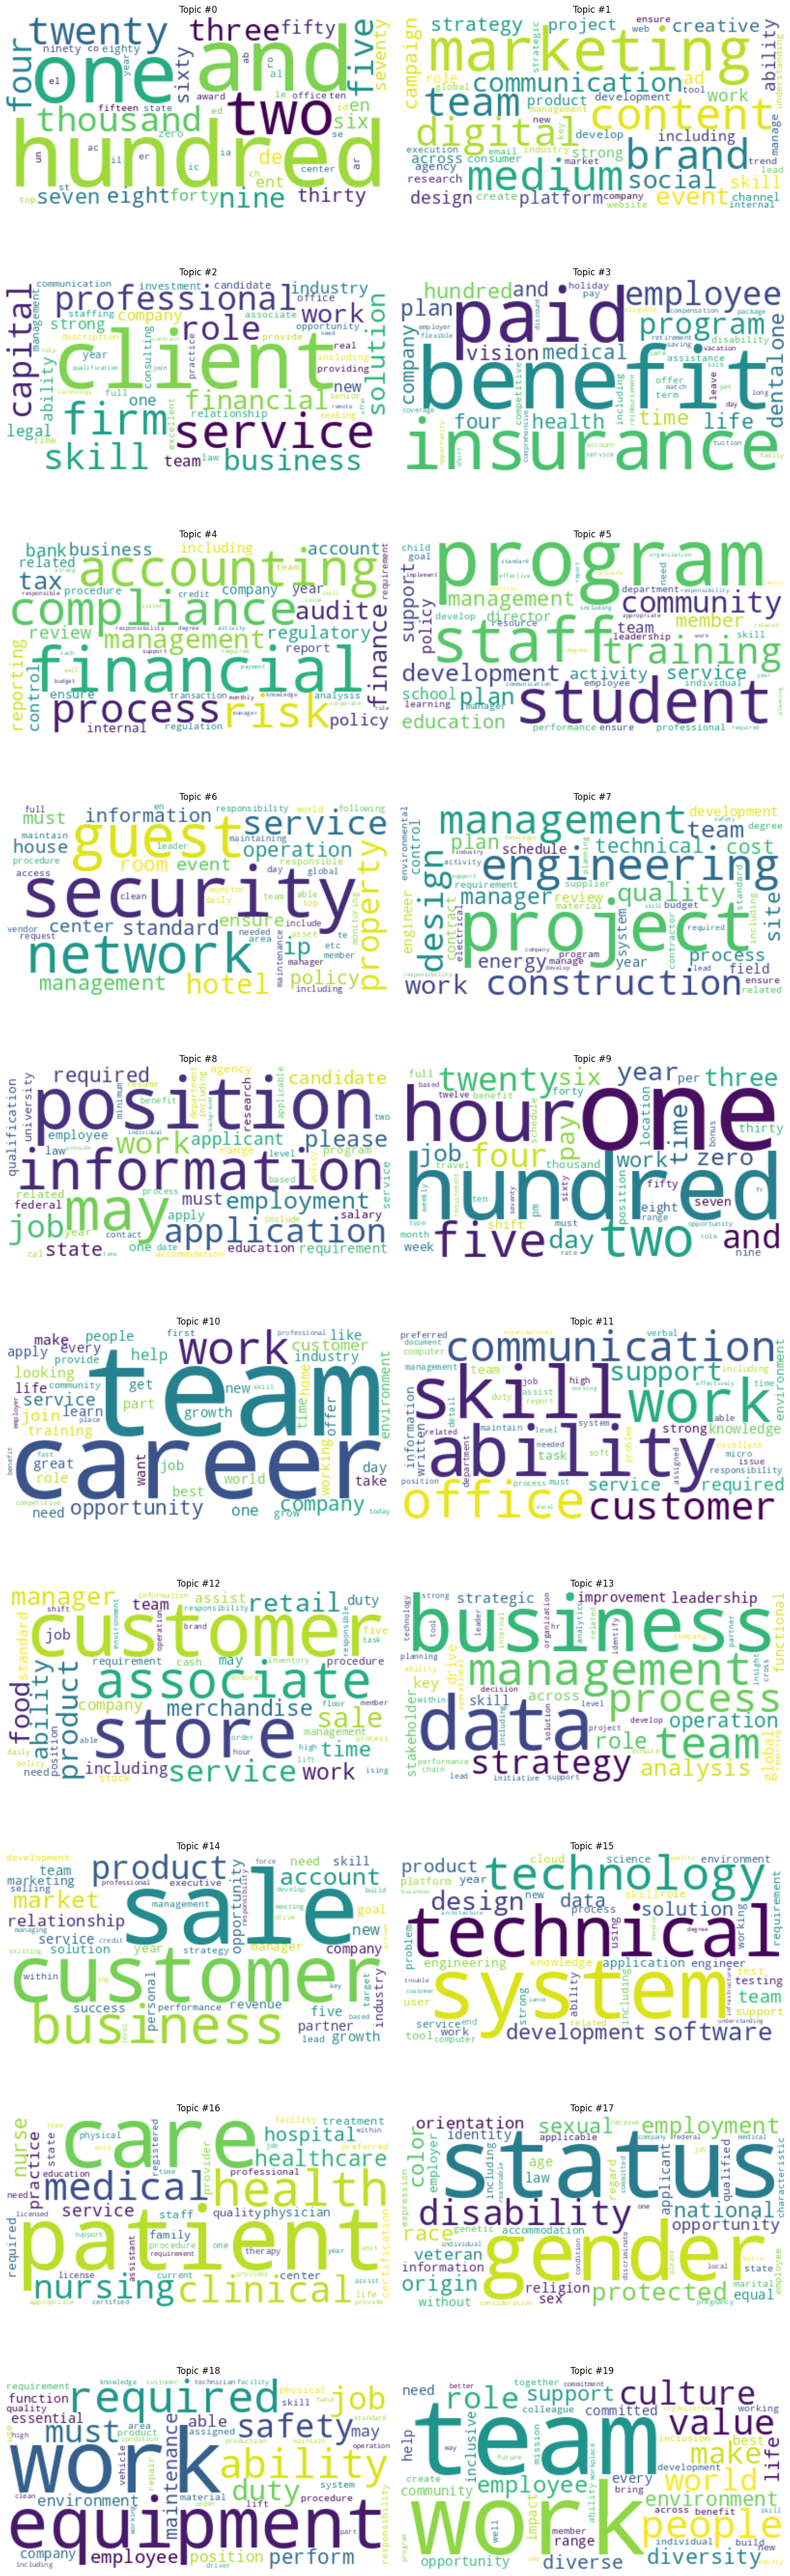

In [36]:
# Generate Word Clouds for top LDA topics
if best_lda_model is not None:
    print("\nGenerating Word Clouds for LDA Topics:")
    num_top_words_wc = 50
    cols = 2 # Adjust grid size as needed
    rows = (best_lda_model.n_components + cols - 1) // cols
    plt.figure(figsize=(15, rows * 5))

    for topic_idx, topic in enumerate(best_lda_model.components_):
        top_features_ind = topic.argsort()[: -num_top_words_wc - 1 : -1]
        top_features = [feature_names_counts[i] for i in top_features_ind]
        word_freq = {feature_names_counts[i]: topic[i] for i in top_features_ind}
        
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
        
        plt.subplot(rows, cols, topic_idx + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic #{topic_idx}')

    plt.tight_layout()
    plt.show()
else:
    print("Skipping word cloud generation, LDA model not available.")

## BERTopic topic modeling

In [30]:

# Import BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import hdbscan
import umap

# Ensure the processed description column is available
if 'processed_description' in df.columns and not df['processed_description'].isnull().all():
    docs = df['processed_description'].tolist()

    # Initialize BERTopic components
    # Use a pre-trained sentence transformer model
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # UMAP for dimensionality reduction
    umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

    # HDBSCAN for clustering
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    # CountVectorizer for topic representation
    vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

    # Initialize BERTopic model
    print("Initializing BERTopic model...")
    topic_model = BERTopic(
        embedding_model=embedding_model,    # Step 1: Embeddings
        umap_model=umap_model,              # Step 2: Dimensionality Reduction
        hdbscan_model=hdbscan_model,        # Step 3: Clustering
        vectorizer_model=vectorizer_model,  # Step 4: Tokenization & Topic Representation
        language="english",
        calculate_probabilities=True,
        verbose=True,
        nr_topics='auto' # Automatically reduce the number of topics
    )

Initializing BERTopic model...


In [31]:
# Fit the model
print("Fitting BERTopic model (this may take some time)...")
topics, probs = topic_model.fit_transform(docs)
print("BERTopic model fitting complete.")

# Get topic information
print("\nBERTopic Model Info:")
freq = topic_model.get_topic_info()
print(f"Number of topics found: {len(freq)}")
display(freq.head(10)) # Display the top 10 topics

# Display top words for a few topics
print("\nTop words per topic (BERTopic):")
for i in range(min(10, len(freq))): # Show top words for the first 10 topics or fewer if less than 10 exist
    topic_nr = freq.iloc[i]['Topic']
    # Skip the outlier topic (-1) if it exists and is among the top
    if topic_nr == -1 and i == 0:
            print(f"\nSkipping outlier topic {-1}")
            if len(freq) > 1: # Check if there's another topic to print
                topic_nr = freq.iloc[1]['Topic'] # Get the next topic
                print(f"\nTopic {topic_nr}:")
                print(topic_model.get_topic(topic_nr))
            continue # Move to the next iteration if only outlier topic exists or after printing the next one
    elif topic_nr != -1:
        print(f"\nTopic {topic_nr}:")
        # Ensure the topic number is valid before getting words
        if topic_nr in topic_model.get_topics():
                print(topic_model.get_topic(topic_nr))
        else:
                print(f"Topic {topic_nr} not found in the main topic set.")


2025-05-03 13:17:44,093 - BERTopic - Embedding - Transforming documents to embeddings.


Fitting BERTopic model (this may take some time)...


Batches: 100%|██████████| 3817/3817 [03:00<00:00, 21.18it/s]
2025-05-03 13:20:51,420 - BERTopic - Embedding - Completed ✓
2025-05-03 13:20:51,421 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-03 13:22:50,268 - BERTopic - Dimensionality - Completed ✓
2025-05-03 13:22:50,270 - BERTopic - Cluster - Start clustering the reduced embeddings
/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=9383) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/gabriel/.

BERTopic model fitting complete.

BERTopic Model Info:
Number of topics found: 1105


Topic  Count                                               Name  \
0     -1  50415                    -1_experience_project_work_team   
1      0   1454                       0_data_analytics_sql_analyst   
2      1   1072                1_marketing_campaign_medium_content   
3      2    964          2_accounting_financial_finance_accountant   
4      3    943  3_project_construction_project manager_project...   
5      4    862  4_administrative_executive_office_executive as...   
6      5    832              5_security_cybersecurity_threat_cyber   
7      6    774                   6_pet_animal_veterinary_grooming   
8      7    766                7_sale_territory_prospect_sale team   
9      8    726            8_risk_audit_compliance_risk management   

                                      Representation  \
0  [experience, project, work, team, skill, abili...   
1  [data, analytics, sql, analyst, data quality, ...   
2  [marketing, campaign, medium, content, social ...   
3  [accounting, financial, finance, accountant, r...   
4  [project, construction, project manager, proje...   
5  [administrative, executive, office, executive ...   
6  [security, cybersecurity, threat, cyber, infor...   
7  [pet, animal, veterinary, grooming, pet care, ...   
8  [sale, territory, prospect, sale team, account...   
9  [risk, audit, compliance, risk management, reg...   

                                 Representative_Docs  
0  [equitable power people individual different c...  
1  [data engineer remote competitive salary bonus...  
2  [passionate sk inc social medium thrive fast p...  
3  [client seeking experienced detail oriented ac...  
4  [construction project manager oversee planning...  
5  [job title executive assistant location men lo...  
6  [minimum qualification bachelor degree least f...  
7  [create healthier brighter future pet pet pare...  
8  [position summary take charge think fast move ...  
9  [west creek one twelve seven one  united state...


Top words per topic (BERTopic):

Skipping outlier topic -1

Topic 0:
[('data', np.float64(0.00802127944279266)), ('analytics', np.float64(0.00303922541136307)), ('sql', np.float64(0.003004435082888781)), ('analyst', np.float64(0.0026239241732688373)), ('data quality', np.float64(0.0023286834763200552)), ('business', np.float64(0.0022719757579346468)), ('data governance', np.float64(0.002249227335472377)), ('analysis', np.float64(0.002131197078097102)), ('governance', np.float64(0.0019748973229983054)), ('power bi', np.float64(0.0019559445457012206))]

Topic 0:
[('data', np.float64(0.00802127944279266)), ('analytics', np.float64(0.00303922541136307)), ('sql', np.float64(0.003004435082888781)), ('analyst', np.float64(0.0026239241732688373)), ('data quality', np.float64(0.0023286834763200552)), ('business', np.float64(0.0022719757579346468)), ('data governance', np.float64(0.002249227335472377)), ('analysis', np.float64(0.002131197078097102)), ('governance', np.float64(0.0019748973229983

### Save the Bertopic model

In [37]:
# Save the BERTopic model
bert_model_path = os.path.join(project_root, 'models', 'bertopic_model')
topic_model.save(bert_model_path)
print(f"Saved BERTopic model to {bert_model_path}")

2025-05-03 20:04:56,928 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Saved BERTopic model to /home/gabriel/dev/SCIA/NLP_Linkedin_offers/models/bertopic_model


In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

# Need tokenized documents (list of lists of strings) for Gensim Dictionary
# Assuming 'processed_description' contains space-separated tokens
if 'processed_description' in df.columns:
    print("\\nCalculating Coherence Scores...")
    tokenized_docs = df['processed_description'].fillna('').apply(lambda x: x.split()).tolist()
    # Create Gensim dictionary and corpus
    dictionary = Dictionary(tokenized_docs)
    # Filter extremes (optional but often helpful)
    dictionary.filter_extremes(no_below=5, no_above=0.90)
    # Use the dictionary used for the sklearn vectorizer to ensure consistency
    # Or create corpus based on the new dictionary
    # Option 1: Use sklearn's vectorizer features if dictionary matches
    # Make sure feature_names_counts matches dictionary.token2id mapping order
    # gensim_corpus = Sparse2Corpus(X_counts, documents_columns=False)

    # Option 2: Create corpus from scratch using the new dictionary
    gensim_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    # Extract topics from sklearn models in the required format (list of lists of top words)
    def get_topics_list(model, feature_names, num_top_words):
        topics_list = []
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics_list.append(top_features)
        return topics_list

    if best_lda_model is not None:
        lda_topics_list = get_topics_list(best_lda_model, feature_names_counts, 10)
        cm_lda = CoherenceModel(topics=lda_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = cm_lda.get_coherence()
        print(f"LDA Coherence Score (C_v): {coherence_lda:.4f}")

    # You might need to retrain NMF on CountVectorizer data for direct comparison,
    # or adapt the TF-IDF features/topics if using the TF-IDF based NMF model.
    # Here we assume best_nmf_model was trained on TF-IDF (feature_names_tfidf)
    # This comparison might be less direct if vectorizers differ significantly.
    if best_nmf_model is not None:
         # Ensure feature_names_tfidf corresponds to the dictionary used for coherence
         # This might require aligning vocabularies or recalculating coherence based on TFIDF features
         # For simplicity, showing calculation assuming alignment:
         nmf_topics_list = get_topics_list(best_nmf_model, feature_names_tfidf, 10)
         # Ensure tokenized_docs and dictionary are appropriate for the NMF features
         cm_nmf = CoherenceModel(topics=nmf_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
         coherence_nmf = cm_nmf.get_coherence()
         print(f"NMF Coherence Score (C_v): {coherence_nmf:.4f}")

else:
    print("Skipping coherence calculation due to missing processed descriptions.")


ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

# Need tokenized documents (list of lists of strings) for Gensim Dictionary
# Assuming 'processed_description' contains space-separated tokens
if 'processed_description' in df.columns:
    print("\\nCalculating Coherence Scores...")
    tokenized_docs = df['processed_description'].fillna('').apply(lambda x: x.split()).tolist()
    # Create Gensim dictionary and corpus
    dictionary = Dictionary(tokenized_docs)
    # Filter extremes (optional but often helpful)
    dictionary.filter_extremes(no_below=5, no_above=0.90)
    # Use the dictionary used for the sklearn vectorizer to ensure consistency
    # Or create corpus based on the new dictionary
    # Option 1: Use sklearn's vectorizer features if dictionary matches
    # Make sure feature_names_counts matches dictionary.token2id mapping order
    # gensim_corpus = Sparse2Corpus(X_counts, documents_columns=False)

    # Option 2: Create corpus from scratch using the new dictionary
    gensim_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    # Extract topics from sklearn models in the required format (list of lists of top words)
    def get_topics_list(model, feature_names, num_top_words):
        topics_list = []
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics_list.append(top_features)
        return topics_list

    if best_lda_model is not None:
        lda_topics_list = get_topics_list(best_lda_model, feature_names_counts, 10)
        cm_lda = CoherenceModel(topics=lda_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = cm_lda.get_coherence()
        print(f"LDA Coherence Score (C_v): {coherence_lda:.4f}")

    # You might need to retrain NMF on CountVectorizer data for direct comparison,
    # or adapt the TF-IDF features/topics if using the TF-IDF based NMF model.
    # Here we assume best_nmf_model was trained on TF-IDF (feature_names_tfidf)
    # This comparison might be less direct if vectorizers differ significantly.
    if best_nmf_model is not None:
         # Ensure feature_names_tfidf corresponds to the dictionary used for coherence
         # This might require aligning vocabularies or recalculating coherence based on TFIDF features
         # For simplicity, showing calculation assuming alignment:
         nmf_topics_list = get_topics_list(best_nmf_model, feature_names_tfidf, 10)
         # Ensure tokenized_docs and dictionary are appropriate for the NMF features
         cm_nmf = CoherenceModel(topics=nmf_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
         coherence_nmf = cm_nmf.get_coherence()
         print(f"NMF Coherence Score (C_v): {coherence_nmf:.4f}")

else:
    print("Skipping coherence calculation due to missing processed descriptions.")


ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

# Need tokenized documents (list of lists of strings) for Gensim Dictionary
# Assuming 'processed_description' contains space-separated tokens
if 'processed_description' in df.columns:
    print("\\nCalculating Coherence Scores...")
    tokenized_docs = df['processed_description'].fillna('').apply(lambda x: x.split()).tolist()
    # Create Gensim dictionary and corpus
    dictionary = Dictionary(tokenized_docs)
    # Filter extremes (optional but often helpful)
    dictionary.filter_extremes(no_below=5, no_above=0.90)
    # Use the dictionary used for the sklearn vectorizer to ensure consistency
    # Or create corpus based on the new dictionary
    # Option 1: Use sklearn's vectorizer features if dictionary matches
    # Make sure feature_names_counts matches dictionary.token2id mapping order
    # gensim_corpus = Sparse2Corpus(X_counts, documents_columns=False)

    # Option 2: Create corpus from scratch using the new dictionary
    gensim_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    # Extract topics from sklearn models in the required format (list of lists of top words)
    def get_topics_list(model, feature_names, num_top_words):
        topics_list = []
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics_list.append(top_features)
        return topics_list

    if best_lda_model is not None:
        lda_topics_list = get_topics_list(best_lda_model, feature_names_counts, 10)
        cm_lda = CoherenceModel(topics=lda_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = cm_lda.get_coherence()
        print(f"LDA Coherence Score (C_v): {coherence_lda:.4f}")

    # You might need to retrain NMF on CountVectorizer data for direct comparison,
    # or adapt the TF-IDF features/topics if using the TF-IDF based NMF model.
    # Here we assume best_nmf_model was trained on TF-IDF (feature_names_tfidf)
    # This comparison might be less direct if vectorizers differ significantly.
    if best_nmf_model is not None:
         # Ensure feature_names_tfidf corresponds to the dictionary used for coherence
         # This might require aligning vocabularies or recalculating coherence based on TFIDF features
         # For simplicity, showing calculation assuming alignment:
         nmf_topics_list = get_topics_list(best_nmf_model, feature_names_tfidf, 10)
         # Ensure tokenized_docs and dictionary are appropriate for the NMF features
         cm_nmf = CoherenceModel(topics=nmf_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
         coherence_nmf = cm_nmf.get_coherence()
         print(f"NMF Coherence Score (C_v): {coherence_nmf:.4f}")

else:
    print("Skipping coherence calculation due to missing processed descriptions.")


ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

# Need tokenized documents (list of lists of strings) for Gensim Dictionary
# Assuming 'processed_description' contains space-separated tokens
if 'processed_description' in df.columns:
    print("\\nCalculating Coherence Scores...")
    tokenized_docs = df['processed_description'].fillna('').apply(lambda x: x.split()).tolist()
    # Create Gensim dictionary and corpus
    dictionary = Dictionary(tokenized_docs)
    # Filter extremes (optional but often helpful)
    dictionary.filter_extremes(no_below=5, no_above=0.90)
    # Use the dictionary used for the sklearn vectorizer to ensure consistency
    # Or create corpus based on the new dictionary
    # Option 1: Use sklearn's vectorizer features if dictionary matches
    # Make sure feature_names_counts matches dictionary.token2id mapping order
    # gensim_corpus = Sparse2Corpus(X_counts, documents_columns=False)

    # Option 2: Create corpus from scratch using the new dictionary
    gensim_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    # Extract topics from sklearn models in the required format (list of lists of top words)
    def get_topics_list(model, feature_names, num_top_words):
        topics_list = []
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics_list.append(top_features)
        return topics_list

    if best_lda_model is not None:
        lda_topics_list = get_topics_list(best_lda_model, feature_names_counts, 10)
        cm_lda = CoherenceModel(topics=lda_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = cm_lda.get_coherence()
        print(f"LDA Coherence Score (C_v): {coherence_lda:.4f}")

    # You might need to retrain NMF on CountVectorizer data for direct comparison,
    # or adapt the TF-IDF features/topics if using the TF-IDF based NMF model.
    # Here we assume best_nmf_model was trained on TF-IDF (feature_names_tfidf)
    # This comparison might be less direct if vectorizers differ significantly.
    if best_nmf_model is not None:
         # Ensure feature_names_tfidf corresponds to the dictionary used for coherence
         # This might require aligning vocabularies or recalculating coherence based on TFIDF features
         # For simplicity, showing calculation assuming alignment:
         nmf_topics_list = get_topics_list(best_nmf_model, feature_names_tfidf, 10)
         # Ensure tokenized_docs and dictionary are appropriate for the NMF features
         cm_nmf = CoherenceModel(topics=nmf_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
         coherence_nmf = cm_nmf.get_coherence()
         print(f"NMF Coherence Score (C_v): {coherence_nmf:.4f}")

else:
    print("Skipping coherence calculation due to missing processed descriptions.")


ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [33]:
# --- Visualizations ---
print("\nGenerating BERTopic visualizations...")

# Visualize topics - interactive plot
try:
    fig1 = topic_model.visualize_topics()
    fig1.show()
except Exception as e:
    print(f"Could not generate visualize_topics plot: {e}")

# Visualize topic hierarchy
try:
    fig2 = topic_model.visualize_hierarchy()
    fig2.show()
except Exception as e:
    print(f"Could not generate visualize_hierarchy plot: {e}")


# Visualize top terms as bar chart
try:
    fig3 = topic_model.visualize_barchart(top_n_topics=12) # Show top 12 topics
    fig3.show()
except Exception as e:
    print(f"Could not generate visualize_barchart plot: {e}")

# Visualize topic similarity heatmap
try:
    fig4 = topic_model.visualize_heatmap(n_clusters=10, top_n_topics=20) # Adjust n_clusters as needed
    fig4.show()
except Exception as e:
    print(f"Could not generate visualize_heatmap plot: {e}")



Generating BERTopic visualizations...
Could not generate visualize_topics plot: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Could not generate visualize_hierarchy plot: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Could not generate visualize_barchart plot: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Could not generate visualize_heatmap plot: Mime type rendering requires nbformat>=4.2.0 but it is not installed


## Conclusion

This notebook explored topic modeling using LDA and NMF. Further steps could include more rigorous hyperparameter tuning, comparing coherence scores, and analyzing the distribution of topics across different job categories or companies.

In [34]:
best_lda_model = lda_search.best_estimator_
best_nmf_model = nmf_model

In [35]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

# Need tokenized documents (list of lists of strings) for Gensim Dictionary
# Assuming 'processed_description' contains space-separated tokens
if 'processed_description' in df.columns:
    print("\\nCalculating Coherence Scores...")
    tokenized_docs = df['processed_description'].fillna('').apply(lambda x: x.split()).tolist()
    # Create Gensim dictionary and corpus
    dictionary = Dictionary(tokenized_docs)
    # Filter extremes (optional but often helpful)
    dictionary.filter_extremes(no_below=5, no_above=0.90)
    # Use the dictionary used for the sklearn vectorizer to ensure consistency
    # Or create corpus based on the new dictionary
    # Option 1: Use sklearn's vectorizer features if dictionary matches
    # Make sure feature_names_counts matches dictionary.token2id mapping order
    # gensim_corpus = Sparse2Corpus(X_counts, documents_columns=False)

    # Option 2: Create corpus from scratch using the new dictionary
    gensim_corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    # Extract topics from sklearn models in the required format (list of lists of top words)
    def get_topics_list(model, feature_names, num_top_words):
        topics_list = []
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            topics_list.append(top_features)
        return topics_list

    if best_lda_model is not None:
        lda_topics_list = get_topics_list(best_lda_model, feature_names_counts, 10)
        cm_lda = CoherenceModel(topics=lda_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = cm_lda.get_coherence()
        print(f"LDA Coherence Score (C_v): {coherence_lda:.4f}")

    # You might need to retrain NMF on CountVectorizer data for direct comparison,
    # or adapt the TF-IDF features/topics if using the TF-IDF based NMF model.
    # Here we assume best_nmf_model was trained on TF-IDF (feature_names_tfidf)
    # This comparison might be less direct if vectorizers differ significantly.
    if best_nmf_model is not None:
         # Ensure feature_names_tfidf corresponds to the dictionary used for coherence
         # This might require aligning vocabularies or recalculating coherence based on TFIDF features
         # For simplicity, showing calculation assuming alignment:
         nmf_topics_list = get_topics_list(best_nmf_model, feature_names_tfidf, 10)
         # Ensure tokenized_docs and dictionary are appropriate for the NMF features
         cm_nmf = CoherenceModel(topics=nmf_topics_list, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
         coherence_nmf = cm_nmf.get_coherence()
         print(f"NMF Coherence Score (C_v): {coherence_nmf:.4f}")

else:
    print("Skipping coherence calculation due to missing processed descriptions.")


ImportError: cannot import name 'triu' from 'scipy.linalg' (/home/gabriel/.cache/pypoetry/virtualenvs/nlp-linkedin-offers-VrYHBMh4-py3.12/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [ ]:
if best_lda_model is not None and X_counts is not None and 'company_name' in df.columns:
    print("\\nAnalyzing Topic Distributions...")
    # Get topic distribution for each document
    doc_topic_dist = best_lda_model.transform(X_counts)
    # Assign dominant topic
    df['dominant_topic_lda'] = np.argmax(doc_topic_dist, axis=1)

    # Display head with dominant topic
    print("DataFrame with Dominant LDA Topic:")
    display(df[['company_name', 'description', 'dominant_topic_lda']].head())

    # Analyze distribution by Company (Top N Companies)
    top_companies = df['company_name'].value_counts().head(10).index.tolist()
    df_top_companies = df[df['company_name'].isin(top_companies)]

    plt.figure(figsize=(12, 8))
    sns.countplot(data=df_top_companies, y='company_name', hue='dominant_topic_lda', order=top_companies)
    plt.title('LDA Topic Distribution across Top 10 Companies')
    plt.xlabel('Number of Job Postings')
    plt.ylabel('Company Name')
    plt.legend(title='Topic #', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Analyze overall topic distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='dominant_topic_lda')
    plt.title('Overall LDA Topic Distribution')
    plt.xlabel('Dominant Topic')
    plt.ylabel('Number of Job Postings')
    plt.show()

    # --- Optional: Add Role Level Analysis (similar to dataset_analysis.ipynb) ---
    # def categorize_role(title):
    #     # ... (copy function from dataset_analysis.ipynb) ...
    # df['role_level'] = df['title'].apply(categorize_role)
    # plt.figure(figsize=(10, 6))
    # sns.countplot(data=df, y='role_level', hue='dominant_topic_lda', order=df['role_level'].value_counts().index)
    # plt.title('LDA Topic Distribution across Role Levels')
    # plt.xlabel('Number of Job Postings')
    # plt.ylabel('Role Level')
    # plt.legend(title='Topic #', bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    # plt.show()

else:
    print("Skipping topic distribution analysis due to missing model, data, or company_name column.")